# HAR CNN training 

In [17]:
# %load utils/utilities.py
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

def standardize(train, test):
	""" Standardize data """

	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

	return X_train, X_test

def one_hot(labels, n_class = 6):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]
	






## Prepare data

In [22]:
rootDatasetDir = "./datasets/"
X_train, labels_train, list_ch_train = read_data(data_path=rootDatasetDir, split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path=rootDatasetDir, split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [23]:
# Normalize
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [24]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [25]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [26]:
# Imports
import tensorflow as tf

### Hyperparameters

In [27]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs =1000

n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [28]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

In [29]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 18)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 18) --> (batch, 16, 36)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 36) --> (batch, 8, 36)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Build the inception layer:

![title](img/HAR_inception.png)

In [30]:
with graph.as_default():
    
    # convolution: input to output of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_11 = tf.layers.conv1d(inputs=max_pool_4, filters=36, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_21 = tf.layers.conv1d(inputs=max_pool_4, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # convolution: input to middle layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 18)
    conv1_31 = tf.layers.conv1d(inputs=max_pool_4, filters=18, kernel_size=1, strides=1,
                               padding='same', activation = tf.nn.relu)
    
    # average pool: input to middle layer of inception
    # (batch, 8, 36) --> (batch, 8, 36)
    avg_pool_41 = tf.layers.average_pooling1d(inputs=max_pool_4, pool_size=2, strides=1, padding='same')
    
    ## Middle layer of inception
    
    # convolution: middle to out layer of inception (size=2)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv2_22 = tf.layers.conv1d(inputs=conv1_21, filters=36, kernel_size=2, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=4)
    # (batch, 8, 18) --> (batch, 8, 36)
    conv4_32 = tf.layers.conv1d(inputs=conv1_31, filters=36, kernel_size=4, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    # convolution: middle to out layer of inception (size=1)
    # (batch, 8, 36) --> (batch, 8, 36)
    conv1_42 = tf.layers.conv1d(inputs=avg_pool_41, filters=36, kernel_size=1, strides=1,
                               padding='same', activation=tf.nn.relu)
    
    ## Out layer: Concatenate filters
    # (batch, 8, 4*36)
    inception_out = tf.concat([conv1_11, conv2_22, conv4_32, conv1_42], axis=2)

Now, flatten and pass to the classifier

In [31]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(inception_out, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [32]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [33]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

('Epoch: 0/1000', 'Iteration: 5', 'Train loss: 1.779963', 'Train acc: 0.171667')
('Epoch: 1/1000', 'Iteration: 10', 'Train loss: 1.763566', 'Train acc: 0.191667')
('Epoch: 1/1000', 'Iteration: 10', 'Validation loss: 1.730630', 'Validation acc: 0.135556')
('Epoch: 1/1000', 'Iteration: 15', 'Train loss: 1.744825', 'Train acc: 0.173333')
('Epoch: 2/1000', 'Iteration: 20', 'Train loss: 1.704408', 'Train acc: 0.168333')
('Epoch: 2/1000', 'Iteration: 20', 'Validation loss: 1.677720', 'Validation acc: 0.141111')
('Epoch: 2/1000', 'Iteration: 25', 'Train loss: 1.676410', 'Train acc: 0.216667')
('Epoch: 3/1000', 'Iteration: 30', 'Train loss: 1.663439', 'Train acc: 0.198333')
('Epoch: 3/1000', 'Iteration: 30', 'Validation loss: 1.630053', 'Validation acc: 0.279444')
('Epoch: 3/1000', 'Iteration: 35', 'Train loss: 1.651053', 'Train acc: 0.220000')
('Epoch: 4/1000', 'Iteration: 40', 'Train loss: 1.616863', 'Train acc: 0.243333')
('Epoch: 4/1000', 'Iteration: 40', 'Validation loss: 1.583624', 'Vali

('Epoch: 36/1000', 'Iteration: 325', 'Train loss: 0.501652', 'Train acc: 0.815000')
('Epoch: 36/1000', 'Iteration: 330', 'Train loss: 0.500670', 'Train acc: 0.810000')
('Epoch: 36/1000', 'Iteration: 330', 'Validation loss: 0.462813', 'Validation acc: 0.861667')
('Epoch: 37/1000', 'Iteration: 335', 'Train loss: 0.469580', 'Train acc: 0.835000')
('Epoch: 37/1000', 'Iteration: 340', 'Train loss: 0.454483', 'Train acc: 0.835000')
('Epoch: 37/1000', 'Iteration: 340', 'Validation loss: 0.436443', 'Validation acc: 0.870556')
('Epoch: 38/1000', 'Iteration: 345', 'Train loss: 0.489871', 'Train acc: 0.803333')
('Epoch: 38/1000', 'Iteration: 350', 'Train loss: 0.456068', 'Train acc: 0.851667')
('Epoch: 38/1000', 'Iteration: 350', 'Validation loss: 0.412108', 'Validation acc: 0.877222')
('Epoch: 39/1000', 'Iteration: 355', 'Train loss: 0.461242', 'Train acc: 0.835000')
('Epoch: 39/1000', 'Iteration: 360', 'Train loss: 0.452306', 'Train acc: 0.846667')
('Epoch: 39/1000', 'Iteration: 360', 'Validati

('Epoch: 71/1000', 'Iteration: 640', 'Train loss: 0.161086', 'Train acc: 0.936667')
('Epoch: 71/1000', 'Iteration: 640', 'Validation loss: 0.155938', 'Validation acc: 0.943889')
('Epoch: 71/1000', 'Iteration: 645', 'Train loss: 0.143420', 'Train acc: 0.943333')
('Epoch: 72/1000', 'Iteration: 650', 'Train loss: 0.147622', 'Train acc: 0.955000')
('Epoch: 72/1000', 'Iteration: 650', 'Validation loss: 0.153679', 'Validation acc: 0.945000')
('Epoch: 72/1000', 'Iteration: 655', 'Train loss: 0.158723', 'Train acc: 0.938333')
('Epoch: 73/1000', 'Iteration: 660', 'Train loss: 0.191814', 'Train acc: 0.918333')
('Epoch: 73/1000', 'Iteration: 660', 'Validation loss: 0.151104', 'Validation acc: 0.943889')
('Epoch: 73/1000', 'Iteration: 665', 'Train loss: 0.151788', 'Train acc: 0.945000')
('Epoch: 74/1000', 'Iteration: 670', 'Train loss: 0.178696', 'Train acc: 0.921667')
('Epoch: 74/1000', 'Iteration: 670', 'Validation loss: 0.149552', 'Validation acc: 0.946667')
('Epoch: 74/1000', 'Iteration: 675',

('Epoch: 106/1000', 'Iteration: 955', 'Train loss: 0.109277', 'Train acc: 0.960000')
('Epoch: 106/1000', 'Iteration: 960', 'Train loss: 0.104763', 'Train acc: 0.953333')
('Epoch: 106/1000', 'Iteration: 960', 'Validation loss: 0.116294', 'Validation acc: 0.954444')
('Epoch: 107/1000', 'Iteration: 965', 'Train loss: 0.115214', 'Train acc: 0.956667')
('Epoch: 107/1000', 'Iteration: 970', 'Train loss: 0.124156', 'Train acc: 0.953333')
('Epoch: 107/1000', 'Iteration: 970', 'Validation loss: 0.115722', 'Validation acc: 0.954444')
('Epoch: 108/1000', 'Iteration: 975', 'Train loss: 0.138706', 'Train acc: 0.938333')
('Epoch: 108/1000', 'Iteration: 980', 'Train loss: 0.096512', 'Train acc: 0.961667')
('Epoch: 108/1000', 'Iteration: 980', 'Validation loss: 0.115364', 'Validation acc: 0.954444')
('Epoch: 109/1000', 'Iteration: 985', 'Train loss: 0.131983', 'Train acc: 0.946667')
('Epoch: 109/1000', 'Iteration: 990', 'Train loss: 0.126799', 'Train acc: 0.946667')
('Epoch: 109/1000', 'Iteration: 990

('Epoch: 140/1000', 'Iteration: 1265', 'Train loss: 0.104577', 'Train acc: 0.953333')
('Epoch: 141/1000', 'Iteration: 1270', 'Train loss: 0.104298', 'Train acc: 0.958333')
('Epoch: 141/1000', 'Iteration: 1270', 'Validation loss: 0.107177', 'Validation acc: 0.955000')
('Epoch: 141/1000', 'Iteration: 1275', 'Train loss: 0.097724', 'Train acc: 0.951667')
('Epoch: 142/1000', 'Iteration: 1280', 'Train loss: 0.103965', 'Train acc: 0.961667')
('Epoch: 142/1000', 'Iteration: 1280', 'Validation loss: 0.106398', 'Validation acc: 0.955000')
('Epoch: 142/1000', 'Iteration: 1285', 'Train loss: 0.109280', 'Train acc: 0.955000')
('Epoch: 143/1000', 'Iteration: 1290', 'Train loss: 0.127591', 'Train acc: 0.938333')
('Epoch: 143/1000', 'Iteration: 1290', 'Validation loss: 0.106388', 'Validation acc: 0.953889')
('Epoch: 143/1000', 'Iteration: 1295', 'Train loss: 0.089761', 'Train acc: 0.960000')
('Epoch: 144/1000', 'Iteration: 1300', 'Train loss: 0.122708', 'Train acc: 0.948333')
('Epoch: 144/1000', 'Ite

('Epoch: 174/1000', 'Iteration: 1575', 'Train loss: 0.109331', 'Train acc: 0.953333')
('Epoch: 175/1000', 'Iteration: 1580', 'Train loss: 0.101478', 'Train acc: 0.955000')
('Epoch: 175/1000', 'Iteration: 1580', 'Validation loss: 0.100963', 'Validation acc: 0.953889')
('Epoch: 176/1000', 'Iteration: 1585', 'Train loss: 0.085929', 'Train acc: 0.968333')
('Epoch: 176/1000', 'Iteration: 1590', 'Train loss: 0.092391', 'Train acc: 0.956667')
('Epoch: 176/1000', 'Iteration: 1590', 'Validation loss: 0.100844', 'Validation acc: 0.953333')
('Epoch: 177/1000', 'Iteration: 1595', 'Train loss: 0.096995', 'Train acc: 0.960000')
('Epoch: 177/1000', 'Iteration: 1600', 'Train loss: 0.101022', 'Train acc: 0.960000')
('Epoch: 177/1000', 'Iteration: 1600', 'Validation loss: 0.100820', 'Validation acc: 0.953333')
('Epoch: 178/1000', 'Iteration: 1605', 'Train loss: 0.119033', 'Train acc: 0.945000')
('Epoch: 178/1000', 'Iteration: 1610', 'Train loss: 0.071842', 'Train acc: 0.971667')
('Epoch: 178/1000', 'Ite

('Epoch: 209/1000', 'Iteration: 1885', 'Train loss: 0.115583', 'Train acc: 0.951667')
('Epoch: 209/1000', 'Iteration: 1890', 'Train loss: 0.098006', 'Train acc: 0.960000')
('Epoch: 209/1000', 'Iteration: 1890', 'Validation loss: 0.097303', 'Validation acc: 0.954444')
('Epoch: 210/1000', 'Iteration: 1895', 'Train loss: 0.094953', 'Train acc: 0.951667')
('Epoch: 211/1000', 'Iteration: 1900', 'Train loss: 0.082089', 'Train acc: 0.963333')
('Epoch: 211/1000', 'Iteration: 1900', 'Validation loss: 0.097009', 'Validation acc: 0.954444')
('Epoch: 211/1000', 'Iteration: 1905', 'Train loss: 0.084781', 'Train acc: 0.960000')
('Epoch: 212/1000', 'Iteration: 1910', 'Train loss: 0.096456', 'Train acc: 0.955000')
('Epoch: 212/1000', 'Iteration: 1910', 'Validation loss: 0.097045', 'Validation acc: 0.954444')
('Epoch: 212/1000', 'Iteration: 1915', 'Train loss: 0.102597', 'Train acc: 0.956667')
('Epoch: 213/1000', 'Iteration: 1920', 'Train loss: 0.109862', 'Train acc: 0.948333')
('Epoch: 213/1000', 'Ite

('Epoch: 243/1000', 'Iteration: 2195', 'Train loss: 0.067198', 'Train acc: 0.970000')
('Epoch: 244/1000', 'Iteration: 2200', 'Train loss: 0.109952', 'Train acc: 0.946667')
('Epoch: 244/1000', 'Iteration: 2200', 'Validation loss: 0.093200', 'Validation acc: 0.957222')
('Epoch: 244/1000', 'Iteration: 2205', 'Train loss: 0.098980', 'Train acc: 0.955000')
('Epoch: 245/1000', 'Iteration: 2210', 'Train loss: 0.092067', 'Train acc: 0.956667')
('Epoch: 245/1000', 'Iteration: 2210', 'Validation loss: 0.092816', 'Validation acc: 0.954444')
('Epoch: 246/1000', 'Iteration: 2215', 'Train loss: 0.080505', 'Train acc: 0.966667')
('Epoch: 246/1000', 'Iteration: 2220', 'Train loss: 0.078205', 'Train acc: 0.961667')
('Epoch: 246/1000', 'Iteration: 2220', 'Validation loss: 0.092594', 'Validation acc: 0.954444')
('Epoch: 247/1000', 'Iteration: 2225', 'Train loss: 0.083498', 'Train acc: 0.960000')
('Epoch: 247/1000', 'Iteration: 2230', 'Train loss: 0.089264', 'Train acc: 0.961667')
('Epoch: 247/1000', 'Ite

('Epoch: 278/1000', 'Iteration: 2505', 'Train loss: 0.101752', 'Train acc: 0.953333')
('Epoch: 278/1000', 'Iteration: 2510', 'Train loss: 0.064292', 'Train acc: 0.975000')
('Epoch: 278/1000', 'Iteration: 2510', 'Validation loss: 0.088442', 'Validation acc: 0.957222')
('Epoch: 279/1000', 'Iteration: 2515', 'Train loss: 0.106652', 'Train acc: 0.950000')
('Epoch: 279/1000', 'Iteration: 2520', 'Train loss: 0.088148', 'Train acc: 0.961667')
('Epoch: 279/1000', 'Iteration: 2520', 'Validation loss: 0.088589', 'Validation acc: 0.957222')
('Epoch: 280/1000', 'Iteration: 2525', 'Train loss: 0.091429', 'Train acc: 0.958333')
('Epoch: 281/1000', 'Iteration: 2530', 'Train loss: 0.068933', 'Train acc: 0.973333')
('Epoch: 281/1000', 'Iteration: 2530', 'Validation loss: 0.088243', 'Validation acc: 0.957778')
('Epoch: 281/1000', 'Iteration: 2535', 'Train loss: 0.070660', 'Train acc: 0.963333')
('Epoch: 282/1000', 'Iteration: 2540', 'Train loss: 0.074496', 'Train acc: 0.965000')
('Epoch: 282/1000', 'Ite

('Epoch: 312/1000', 'Iteration: 2815', 'Train loss: 0.083056', 'Train acc: 0.966667')
('Epoch: 313/1000', 'Iteration: 2820', 'Train loss: 0.094623', 'Train acc: 0.955000')
('Epoch: 313/1000', 'Iteration: 2820', 'Validation loss: 0.083152', 'Validation acc: 0.961667')
('Epoch: 313/1000', 'Iteration: 2825', 'Train loss: 0.056212', 'Train acc: 0.980000')
('Epoch: 314/1000', 'Iteration: 2830', 'Train loss: 0.098146', 'Train acc: 0.953333')
('Epoch: 314/1000', 'Iteration: 2830', 'Validation loss: 0.083159', 'Validation acc: 0.961667')
('Epoch: 314/1000', 'Iteration: 2835', 'Train loss: 0.076354', 'Train acc: 0.970000')
('Epoch: 315/1000', 'Iteration: 2840', 'Train loss: 0.074736', 'Train acc: 0.961667')
('Epoch: 315/1000', 'Iteration: 2840', 'Validation loss: 0.083078', 'Validation acc: 0.961111')
('Epoch: 316/1000', 'Iteration: 2845', 'Train loss: 0.064619', 'Train acc: 0.971667')
('Epoch: 316/1000', 'Iteration: 2850', 'Train loss: 0.068268', 'Train acc: 0.965000')
('Epoch: 316/1000', 'Ite

('Epoch: 347/1000', 'Iteration: 3125', 'Train loss: 0.059406', 'Train acc: 0.973333')
('Epoch: 347/1000', 'Iteration: 3130', 'Train loss: 0.070524', 'Train acc: 0.973333')
('Epoch: 347/1000', 'Iteration: 3130', 'Validation loss: 0.076790', 'Validation acc: 0.965000')
('Epoch: 348/1000', 'Iteration: 3135', 'Train loss: 0.087522', 'Train acc: 0.956667')
('Epoch: 348/1000', 'Iteration: 3140', 'Train loss: 0.045912', 'Train acc: 0.985000')
('Epoch: 348/1000', 'Iteration: 3140', 'Validation loss: 0.075994', 'Validation acc: 0.964444')
('Epoch: 349/1000', 'Iteration: 3145', 'Train loss: 0.089133', 'Train acc: 0.960000')
('Epoch: 349/1000', 'Iteration: 3150', 'Train loss: 0.068625', 'Train acc: 0.970000')
('Epoch: 349/1000', 'Iteration: 3150', 'Validation loss: 0.075954', 'Validation acc: 0.965555')
('Epoch: 350/1000', 'Iteration: 3155', 'Train loss: 0.071213', 'Train acc: 0.965000')
('Epoch: 351/1000', 'Iteration: 3160', 'Train loss: 0.056240', 'Train acc: 0.978333')
('Epoch: 351/1000', 'Ite

('Epoch: 381/1000', 'Iteration: 3435', 'Train loss: 0.056555', 'Train acc: 0.971667')
('Epoch: 382/1000', 'Iteration: 3440', 'Train loss: 0.050749', 'Train acc: 0.976667')
('Epoch: 382/1000', 'Iteration: 3440', 'Validation loss: 0.071004', 'Validation acc: 0.972778')
('Epoch: 382/1000', 'Iteration: 3445', 'Train loss: 0.061316', 'Train acc: 0.966667')
('Epoch: 383/1000', 'Iteration: 3450', 'Train loss: 0.078401', 'Train acc: 0.961667')
('Epoch: 383/1000', 'Iteration: 3450', 'Validation loss: 0.071031', 'Validation acc: 0.973333')
('Epoch: 383/1000', 'Iteration: 3455', 'Train loss: 0.045736', 'Train acc: 0.981667')
('Epoch: 384/1000', 'Iteration: 3460', 'Train loss: 0.087144', 'Train acc: 0.956667')
('Epoch: 384/1000', 'Iteration: 3460', 'Validation loss: 0.071002', 'Validation acc: 0.972778')
('Epoch: 384/1000', 'Iteration: 3465', 'Train loss: 0.060718', 'Train acc: 0.970000')
('Epoch: 385/1000', 'Iteration: 3470', 'Train loss: 0.066240', 'Train acc: 0.966667')
('Epoch: 385/1000', 'Ite

('Epoch: 416/1000', 'Iteration: 3745', 'Train loss: 0.040556', 'Train acc: 0.986667')
('Epoch: 416/1000', 'Iteration: 3750', 'Train loss: 0.047119', 'Train acc: 0.976667')
('Epoch: 416/1000', 'Iteration: 3750', 'Validation loss: 0.065807', 'Validation acc: 0.974444')
('Epoch: 417/1000', 'Iteration: 3755', 'Train loss: 0.044254', 'Train acc: 0.980000')
('Epoch: 417/1000', 'Iteration: 3760', 'Train loss: 0.054091', 'Train acc: 0.978333')
('Epoch: 417/1000', 'Iteration: 3760', 'Validation loss: 0.065317', 'Validation acc: 0.975000')
('Epoch: 418/1000', 'Iteration: 3765', 'Train loss: 0.061778', 'Train acc: 0.973333')
('Epoch: 418/1000', 'Iteration: 3770', 'Train loss: 0.037707', 'Train acc: 0.986667')
('Epoch: 418/1000', 'Iteration: 3770', 'Validation loss: 0.065114', 'Validation acc: 0.975000')
('Epoch: 419/1000', 'Iteration: 3775', 'Train loss: 0.075866', 'Train acc: 0.966667')
('Epoch: 419/1000', 'Iteration: 3780', 'Train loss: 0.053614', 'Train acc: 0.973333')
('Epoch: 419/1000', 'Ite

('Epoch: 450/1000', 'Iteration: 4055', 'Train loss: 0.056841', 'Train acc: 0.966667')
('Epoch: 451/1000', 'Iteration: 4060', 'Train loss: 0.038530', 'Train acc: 0.986667')
('Epoch: 451/1000', 'Iteration: 4060', 'Validation loss: 0.062139', 'Validation acc: 0.978889')
('Epoch: 451/1000', 'Iteration: 4065', 'Train loss: 0.037245', 'Train acc: 0.986667')
('Epoch: 452/1000', 'Iteration: 4070', 'Train loss: 0.037413', 'Train acc: 0.981667')
('Epoch: 452/1000', 'Iteration: 4070', 'Validation loss: 0.061015', 'Validation acc: 0.976667')
('Epoch: 452/1000', 'Iteration: 4075', 'Train loss: 0.046887', 'Train acc: 0.981667')
('Epoch: 453/1000', 'Iteration: 4080', 'Train loss: 0.052040', 'Train acc: 0.976667')
('Epoch: 453/1000', 'Iteration: 4080', 'Validation loss: 0.060809', 'Validation acc: 0.977222')
('Epoch: 453/1000', 'Iteration: 4085', 'Train loss: 0.028191', 'Train acc: 0.990000')
('Epoch: 454/1000', 'Iteration: 4090', 'Train loss: 0.072946', 'Train acc: 0.961667')
('Epoch: 454/1000', 'Ite

('Epoch: 484/1000', 'Iteration: 4365', 'Train loss: 0.038555', 'Train acc: 0.983333')
('Epoch: 485/1000', 'Iteration: 4370', 'Train loss: 0.046787', 'Train acc: 0.981667')
('Epoch: 485/1000', 'Iteration: 4370', 'Validation loss: 0.056929', 'Validation acc: 0.979445')
('Epoch: 486/1000', 'Iteration: 4375', 'Train loss: 0.029686', 'Train acc: 0.991667')
('Epoch: 486/1000', 'Iteration: 4380', 'Train loss: 0.029759', 'Train acc: 0.991667')
('Epoch: 486/1000', 'Iteration: 4380', 'Validation loss: 0.056469', 'Validation acc: 0.980556')
('Epoch: 487/1000', 'Iteration: 4385', 'Train loss: 0.033490', 'Train acc: 0.983333')
('Epoch: 487/1000', 'Iteration: 4390', 'Train loss: 0.040060', 'Train acc: 0.980000')
('Epoch: 487/1000', 'Iteration: 4390', 'Validation loss: 0.056832', 'Validation acc: 0.981111')
('Epoch: 488/1000', 'Iteration: 4395', 'Train loss: 0.048098', 'Train acc: 0.980000')
('Epoch: 488/1000', 'Iteration: 4400', 'Train loss: 0.028848', 'Train acc: 0.986667')
('Epoch: 488/1000', 'Ite

('Epoch: 519/1000', 'Iteration: 4675', 'Train loss: 0.056952', 'Train acc: 0.978333')
('Epoch: 519/1000', 'Iteration: 4680', 'Train loss: 0.034647', 'Train acc: 0.985000')
('Epoch: 519/1000', 'Iteration: 4680', 'Validation loss: 0.054736', 'Validation acc: 0.981111')
('Epoch: 520/1000', 'Iteration: 4685', 'Train loss: 0.046015', 'Train acc: 0.978333')
('Epoch: 521/1000', 'Iteration: 4690', 'Train loss: 0.031664', 'Train acc: 0.990000')
('Epoch: 521/1000', 'Iteration: 4690', 'Validation loss: 0.054579', 'Validation acc: 0.981667')
('Epoch: 521/1000', 'Iteration: 4695', 'Train loss: 0.023527', 'Train acc: 0.996667')
('Epoch: 522/1000', 'Iteration: 4700', 'Train loss: 0.029487', 'Train acc: 0.985000')
('Epoch: 522/1000', 'Iteration: 4700', 'Validation loss: 0.054865', 'Validation acc: 0.979445')
('Epoch: 522/1000', 'Iteration: 4705', 'Train loss: 0.030790', 'Train acc: 0.990000')
('Epoch: 523/1000', 'Iteration: 4710', 'Train loss: 0.040896', 'Train acc: 0.981667')
('Epoch: 523/1000', 'Ite

('Epoch: 553/1000', 'Iteration: 4985', 'Train loss: 0.023922', 'Train acc: 0.990000')
('Epoch: 554/1000', 'Iteration: 4990', 'Train loss: 0.047496', 'Train acc: 0.980000')
('Epoch: 554/1000', 'Iteration: 4990', 'Validation loss: 0.052776', 'Validation acc: 0.980556')
('Epoch: 554/1000', 'Iteration: 4995', 'Train loss: 0.027190', 'Train acc: 0.988333')
('Epoch: 555/1000', 'Iteration: 5000', 'Train loss: 0.046999', 'Train acc: 0.971667')
('Epoch: 555/1000', 'Iteration: 5000', 'Validation loss: 0.052921', 'Validation acc: 0.982778')
('Epoch: 556/1000', 'Iteration: 5005', 'Train loss: 0.021659', 'Train acc: 0.996667')
('Epoch: 556/1000', 'Iteration: 5010', 'Train loss: 0.022971', 'Train acc: 0.993333')
('Epoch: 556/1000', 'Iteration: 5010', 'Validation loss: 0.053463', 'Validation acc: 0.981667')
('Epoch: 557/1000', 'Iteration: 5015', 'Train loss: 0.033082', 'Train acc: 0.983333')
('Epoch: 557/1000', 'Iteration: 5020', 'Train loss: 0.030007', 'Train acc: 0.988333')
('Epoch: 557/1000', 'Ite

('Epoch: 588/1000', 'Iteration: 5295', 'Train loss: 0.030676', 'Train acc: 0.991667')
('Epoch: 588/1000', 'Iteration: 5300', 'Train loss: 0.026501', 'Train acc: 0.986667')
('Epoch: 588/1000', 'Iteration: 5300', 'Validation loss: 0.052194', 'Validation acc: 0.982222')
('Epoch: 589/1000', 'Iteration: 5305', 'Train loss: 0.047674', 'Train acc: 0.980000')
('Epoch: 589/1000', 'Iteration: 5310', 'Train loss: 0.026042', 'Train acc: 0.986667')
('Epoch: 589/1000', 'Iteration: 5310', 'Validation loss: 0.053525', 'Validation acc: 0.982222')
('Epoch: 590/1000', 'Iteration: 5315', 'Train loss: 0.032757', 'Train acc: 0.986667')
('Epoch: 591/1000', 'Iteration: 5320', 'Train loss: 0.023414', 'Train acc: 0.995000')
('Epoch: 591/1000', 'Iteration: 5320', 'Validation loss: 0.053275', 'Validation acc: 0.983333')
('Epoch: 591/1000', 'Iteration: 5325', 'Train loss: 0.018960', 'Train acc: 0.996667')
('Epoch: 592/1000', 'Iteration: 5330', 'Train loss: 0.027156', 'Train acc: 0.986667')
('Epoch: 592/1000', 'Ite

('Epoch: 622/1000', 'Iteration: 5605', 'Train loss: 0.018458', 'Train acc: 0.993333')
('Epoch: 623/1000', 'Iteration: 5610', 'Train loss: 0.023098', 'Train acc: 0.996667')
('Epoch: 623/1000', 'Iteration: 5610', 'Validation loss: 0.053422', 'Validation acc: 0.981667')
('Epoch: 623/1000', 'Iteration: 5615', 'Train loss: 0.020037', 'Train acc: 0.990000')
('Epoch: 624/1000', 'Iteration: 5620', 'Train loss: 0.040547', 'Train acc: 0.981667')
('Epoch: 624/1000', 'Iteration: 5620', 'Validation loss: 0.053734', 'Validation acc: 0.982222')
('Epoch: 624/1000', 'Iteration: 5625', 'Train loss: 0.025517', 'Train acc: 0.986667')
('Epoch: 625/1000', 'Iteration: 5630', 'Train loss: 0.027426', 'Train acc: 0.990000')
('Epoch: 625/1000', 'Iteration: 5630', 'Validation loss: 0.053834', 'Validation acc: 0.982778')
('Epoch: 626/1000', 'Iteration: 5635', 'Train loss: 0.020747', 'Train acc: 0.995000')
('Epoch: 626/1000', 'Iteration: 5640', 'Train loss: 0.016069', 'Train acc: 0.995000')
('Epoch: 626/1000', 'Ite

('Epoch: 657/1000', 'Iteration: 5915', 'Train loss: 0.016059', 'Train acc: 0.990000')
('Epoch: 657/1000', 'Iteration: 5920', 'Train loss: 0.016762', 'Train acc: 0.995000')
('Epoch: 657/1000', 'Iteration: 5920', 'Validation loss: 0.053881', 'Validation acc: 0.982222')
('Epoch: 658/1000', 'Iteration: 5925', 'Train loss: 0.022378', 'Train acc: 0.990000')
('Epoch: 658/1000', 'Iteration: 5930', 'Train loss: 0.016756', 'Train acc: 0.993333')
('Epoch: 658/1000', 'Iteration: 5930', 'Validation loss: 0.054572', 'Validation acc: 0.982778')
('Epoch: 659/1000', 'Iteration: 5935', 'Train loss: 0.039956', 'Train acc: 0.981667')
('Epoch: 659/1000', 'Iteration: 5940', 'Train loss: 0.019517', 'Train acc: 0.995000')
('Epoch: 659/1000', 'Iteration: 5940', 'Validation loss: 0.054042', 'Validation acc: 0.982222')
('Epoch: 660/1000', 'Iteration: 5945', 'Train loss: 0.027145', 'Train acc: 0.990000')
('Epoch: 661/1000', 'Iteration: 5950', 'Train loss: 0.015790', 'Train acc: 0.996667')
('Epoch: 661/1000', 'Ite

('Epoch: 691/1000', 'Iteration: 6225', 'Train loss: 0.009459', 'Train acc: 1.000000')
('Epoch: 692/1000', 'Iteration: 6230', 'Train loss: 0.021036', 'Train acc: 0.991667')
('Epoch: 692/1000', 'Iteration: 6230', 'Validation loss: 0.054981', 'Validation acc: 0.982222')
('Epoch: 692/1000', 'Iteration: 6235', 'Train loss: 0.014227', 'Train acc: 0.995000')
('Epoch: 693/1000', 'Iteration: 6240', 'Train loss: 0.020284', 'Train acc: 0.996667')
('Epoch: 693/1000', 'Iteration: 6240', 'Validation loss: 0.055472', 'Validation acc: 0.981667')
('Epoch: 693/1000', 'Iteration: 6245', 'Train loss: 0.018623', 'Train acc: 0.988333')
('Epoch: 694/1000', 'Iteration: 6250', 'Train loss: 0.030169', 'Train acc: 0.986667')
('Epoch: 694/1000', 'Iteration: 6250', 'Validation loss: 0.055921', 'Validation acc: 0.982222')
('Epoch: 694/1000', 'Iteration: 6255', 'Train loss: 0.017763', 'Train acc: 0.991667')
('Epoch: 695/1000', 'Iteration: 6260', 'Train loss: 0.023910', 'Train acc: 0.991667')
('Epoch: 695/1000', 'Ite

('Epoch: 726/1000', 'Iteration: 6535', 'Train loss: 0.011584', 'Train acc: 0.998333')
('Epoch: 726/1000', 'Iteration: 6540', 'Train loss: 0.010185', 'Train acc: 0.998333')
('Epoch: 726/1000', 'Iteration: 6540', 'Validation loss: 0.055611', 'Validation acc: 0.983889')
('Epoch: 727/1000', 'Iteration: 6545', 'Train loss: 0.017608', 'Train acc: 0.993333')
('Epoch: 727/1000', 'Iteration: 6550', 'Train loss: 0.016618', 'Train acc: 0.993333')
('Epoch: 727/1000', 'Iteration: 6550', 'Validation loss: 0.055947', 'Validation acc: 0.985000')
('Epoch: 728/1000', 'Iteration: 6555', 'Train loss: 0.015729', 'Train acc: 0.998333')
('Epoch: 728/1000', 'Iteration: 6560', 'Train loss: 0.013098', 'Train acc: 0.995000')
('Epoch: 728/1000', 'Iteration: 6560', 'Validation loss: 0.056802', 'Validation acc: 0.986111')
('Epoch: 729/1000', 'Iteration: 6565', 'Train loss: 0.030860', 'Train acc: 0.988333')
('Epoch: 729/1000', 'Iteration: 6570', 'Train loss: 0.019546', 'Train acc: 0.990000')
('Epoch: 729/1000', 'Ite

('Epoch: 760/1000', 'Iteration: 6845', 'Train loss: 0.019330', 'Train acc: 0.993333')
('Epoch: 761/1000', 'Iteration: 6850', 'Train loss: 0.010942', 'Train acc: 0.996667')
('Epoch: 761/1000', 'Iteration: 6850', 'Validation loss: 0.054459', 'Validation acc: 0.986111')
('Epoch: 761/1000', 'Iteration: 6855', 'Train loss: 0.009353', 'Train acc: 1.000000')
('Epoch: 762/1000', 'Iteration: 6860', 'Train loss: 0.017247', 'Train acc: 0.993333')
('Epoch: 762/1000', 'Iteration: 6860', 'Validation loss: 0.055085', 'Validation acc: 0.985000')
('Epoch: 762/1000', 'Iteration: 6865', 'Train loss: 0.011834', 'Train acc: 0.996667')
('Epoch: 763/1000', 'Iteration: 6870', 'Train loss: 0.017110', 'Train acc: 0.995000')
('Epoch: 763/1000', 'Iteration: 6870', 'Validation loss: 0.055899', 'Validation acc: 0.986111')
('Epoch: 763/1000', 'Iteration: 6875', 'Train loss: 0.014540', 'Train acc: 0.993333')
('Epoch: 764/1000', 'Iteration: 6880', 'Train loss: 0.023136', 'Train acc: 0.991667')
('Epoch: 764/1000', 'Ite

('Epoch: 794/1000', 'Iteration: 7155', 'Train loss: 0.014706', 'Train acc: 0.991667')
('Epoch: 795/1000', 'Iteration: 7160', 'Train loss: 0.014483', 'Train acc: 0.996667')
('Epoch: 795/1000', 'Iteration: 7160', 'Validation loss: 0.058752', 'Validation acc: 0.987222')
('Epoch: 796/1000', 'Iteration: 7165', 'Train loss: 0.010988', 'Train acc: 0.993333')
('Epoch: 796/1000', 'Iteration: 7170', 'Train loss: 0.006483', 'Train acc: 1.000000')
('Epoch: 796/1000', 'Iteration: 7170', 'Validation loss: 0.059203', 'Validation acc: 0.984444')
('Epoch: 797/1000', 'Iteration: 7175', 'Train loss: 0.013302', 'Train acc: 0.995000')
('Epoch: 797/1000', 'Iteration: 7180', 'Train loss: 0.008987', 'Train acc: 0.998333')
('Epoch: 797/1000', 'Iteration: 7180', 'Validation loss: 0.056887', 'Validation acc: 0.986111')
('Epoch: 798/1000', 'Iteration: 7185', 'Train loss: 0.013130', 'Train acc: 0.996667')
('Epoch: 798/1000', 'Iteration: 7190', 'Train loss: 0.009621', 'Train acc: 0.995000')
('Epoch: 798/1000', 'Ite

('Epoch: 829/1000', 'Iteration: 7465', 'Train loss: 0.022683', 'Train acc: 0.990000')
('Epoch: 829/1000', 'Iteration: 7470', 'Train loss: 0.015653', 'Train acc: 0.993333')
('Epoch: 829/1000', 'Iteration: 7470', 'Validation loss: 0.058604', 'Validation acc: 0.986667')
('Epoch: 830/1000', 'Iteration: 7475', 'Train loss: 0.018024', 'Train acc: 0.991667')
('Epoch: 831/1000', 'Iteration: 7480', 'Train loss: 0.009008', 'Train acc: 0.998333')
('Epoch: 831/1000', 'Iteration: 7480', 'Validation loss: 0.061177', 'Validation acc: 0.987222')
('Epoch: 831/1000', 'Iteration: 7485', 'Train loss: 0.005802', 'Train acc: 0.998333')
('Epoch: 832/1000', 'Iteration: 7490', 'Train loss: 0.015462', 'Train acc: 0.995000')
('Epoch: 832/1000', 'Iteration: 7490', 'Validation loss: 0.059331', 'Validation acc: 0.986111')
('Epoch: 832/1000', 'Iteration: 7495', 'Train loss: 0.008207', 'Train acc: 0.998333')
('Epoch: 833/1000', 'Iteration: 7500', 'Train loss: 0.011540', 'Train acc: 0.998333')
('Epoch: 833/1000', 'Ite

('Epoch: 863/1000', 'Iteration: 7775', 'Train loss: 0.010547', 'Train acc: 0.995000')
('Epoch: 864/1000', 'Iteration: 7780', 'Train loss: 0.017204', 'Train acc: 0.991667')
('Epoch: 864/1000', 'Iteration: 7780', 'Validation loss: 0.063522', 'Validation acc: 0.987222')
('Epoch: 864/1000', 'Iteration: 7785', 'Train loss: 0.011464', 'Train acc: 0.995000')
('Epoch: 865/1000', 'Iteration: 7790', 'Train loss: 0.013238', 'Train acc: 0.995000')
('Epoch: 865/1000', 'Iteration: 7790', 'Validation loss: 0.063552', 'Validation acc: 0.985556')
('Epoch: 866/1000', 'Iteration: 7795', 'Train loss: 0.005442', 'Train acc: 1.000000')
('Epoch: 866/1000', 'Iteration: 7800', 'Train loss: 0.006761', 'Train acc: 1.000000')
('Epoch: 866/1000', 'Iteration: 7800', 'Validation loss: 0.062999', 'Validation acc: 0.986667')
('Epoch: 867/1000', 'Iteration: 7805', 'Train loss: 0.011651', 'Train acc: 0.996667')
('Epoch: 867/1000', 'Iteration: 7810', 'Train loss: 0.007751', 'Train acc: 0.998333')
('Epoch: 867/1000', 'Ite

('Epoch: 898/1000', 'Iteration: 8085', 'Train loss: 0.008661', 'Train acc: 1.000000')
('Epoch: 898/1000', 'Iteration: 8090', 'Train loss: 0.007516', 'Train acc: 0.998333')
('Epoch: 898/1000', 'Iteration: 8090', 'Validation loss: 0.064170', 'Validation acc: 0.987778')
('Epoch: 899/1000', 'Iteration: 8095', 'Train loss: 0.017003', 'Train acc: 0.995000')
('Epoch: 899/1000', 'Iteration: 8100', 'Train loss: 0.012094', 'Train acc: 0.995000')
('Epoch: 899/1000', 'Iteration: 8100', 'Validation loss: 0.062773', 'Validation acc: 0.987222')
('Epoch: 900/1000', 'Iteration: 8105', 'Train loss: 0.012400', 'Train acc: 0.995000')
('Epoch: 901/1000', 'Iteration: 8110', 'Train loss: 0.006331', 'Train acc: 0.998333')
('Epoch: 901/1000', 'Iteration: 8110', 'Validation loss: 0.062800', 'Validation acc: 0.987778')
('Epoch: 901/1000', 'Iteration: 8115', 'Train loss: 0.004084', 'Train acc: 1.000000')
('Epoch: 902/1000', 'Iteration: 8120', 'Train loss: 0.008137', 'Train acc: 0.998333')
('Epoch: 902/1000', 'Ite

('Epoch: 932/1000', 'Iteration: 8395', 'Train loss: 0.007799', 'Train acc: 0.998333')
('Epoch: 933/1000', 'Iteration: 8400', 'Train loss: 0.009588', 'Train acc: 0.998333')
('Epoch: 933/1000', 'Iteration: 8400', 'Validation loss: 0.065149', 'Validation acc: 0.985556')
('Epoch: 933/1000', 'Iteration: 8405', 'Train loss: 0.007139', 'Train acc: 0.996667')
('Epoch: 934/1000', 'Iteration: 8410', 'Train loss: 0.012472', 'Train acc: 0.998333')
('Epoch: 934/1000', 'Iteration: 8410', 'Validation loss: 0.064357', 'Validation acc: 0.988333')
('Epoch: 934/1000', 'Iteration: 8415', 'Train loss: 0.008294', 'Train acc: 0.998333')
('Epoch: 935/1000', 'Iteration: 8420', 'Train loss: 0.011278', 'Train acc: 0.996667')
('Epoch: 935/1000', 'Iteration: 8420', 'Validation loss: 0.063549', 'Validation acc: 0.987778')
('Epoch: 936/1000', 'Iteration: 8425', 'Train loss: 0.006232', 'Train acc: 0.998333')
('Epoch: 936/1000', 'Iteration: 8430', 'Train loss: 0.005244', 'Train acc: 0.998333')
('Epoch: 936/1000', 'Ite

('Epoch: 967/1000', 'Iteration: 8705', 'Train loss: 0.005287', 'Train acc: 0.998333')
('Epoch: 967/1000', 'Iteration: 8710', 'Train loss: 0.004769', 'Train acc: 1.000000')
('Epoch: 967/1000', 'Iteration: 8710', 'Validation loss: 0.063945', 'Validation acc: 0.987222')
('Epoch: 968/1000', 'Iteration: 8715', 'Train loss: 0.006593', 'Train acc: 1.000000')
('Epoch: 968/1000', 'Iteration: 8720', 'Train loss: 0.005324', 'Train acc: 1.000000')
('Epoch: 968/1000', 'Iteration: 8720', 'Validation loss: 0.065059', 'Validation acc: 0.987778')
('Epoch: 969/1000', 'Iteration: 8725', 'Train loss: 0.012035', 'Train acc: 0.996667')
('Epoch: 969/1000', 'Iteration: 8730', 'Train loss: 0.005597', 'Train acc: 0.998333')
('Epoch: 969/1000', 'Iteration: 8730', 'Validation loss: 0.064467', 'Validation acc: 0.987778')
('Epoch: 970/1000', 'Iteration: 8735', 'Train loss: 0.007410', 'Train acc: 1.000000')
('Epoch: 971/1000', 'Iteration: 8740', 'Train loss: 0.004909', 'Train acc: 1.000000')
('Epoch: 971/1000', 'Ite

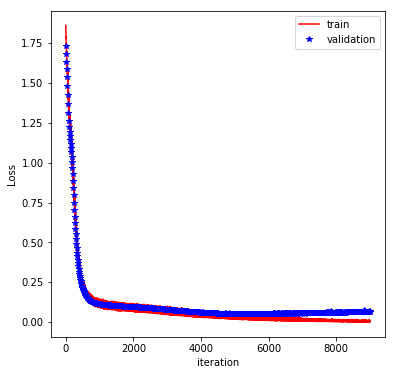

In [ ]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [ ]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))